In [1]:
class ScratchLogisticRegression():
    """
    parameter
    ---------
    max_iter: int : default 100
      イテレーション回数
    lr : float : default 0.01
      learning_rate
    penalty_coefficient : float : default 1.0 
      正則化項の重み(lambda)
    verbose : bool : default False
      学習記録の視覚化
    random_state : bool default False
      乱数を固定するか

    
    Attribute
    ---------
    coef_ : ndarrya (n_features, 1)
      特徴量の重みベクトル
    loss : 次の形のndarray shape(max_iter, 1)
      iter毎のloss 
    val_loss : 次の形のndarray shape(max_iter, 1)
      iter毎のvalidation_loss
    
    """
    
    def __init__(self, max_iter=100, lr=0.01, penalty_coefficient=1.0 , verbose=False, random_state=False):
        # parameterを属性として記録
        self.max_iter = max_iter
        self.lr = lr
        self.penalty_coefficient = penalty_coefficient
        self.random_state = random_state
        
        self.loss = np.zeros(max_iter)
        self.val_loss = np.zeros(max_iter)
        
    def sigmoid_function(self, X):
        return  1/(1+np.exp(-X))
    
    def _sigmoid_linear_hypothesis(self, X):
        """
        線形の関数を仮定してシグモイド関数の引数にすることで確率に置き換える
        
        Parameters
        ----------
        X : 次の形のndarray, shpae(n_samples, n_features)
          学習データ
        
        
        Returns
        -------
        次の形のndarray, shape (n_samples,)
        [0or1]の推定結果
        
        
        """
        # Xとthetaの行列積の計算
        x_theta = np.dot(X, self.coef_)
        # シグモイド関数の引数にする
        sigmoid_x_theta = self.sigmoid_function(x_theta)
        
        return sigmoid_x_theta
    
    def cross_entropy_error(self, X, y):
        """
        目的関数としてcross_entropyを導入する
        
        X : 次の形のndarray, shpae(n_samples, n_features)
          学習データ
        y : 次の形のndarray, shpae(n_samples,1)
          正解ラベル
          
        return
        cross_entropy_error : np.float
          cross_entropy
        """
        # yを整形
        y = y.reshape(-1,1)
        #  _sigmoid_linear_hypothesisからσ(hθx)を変数に代入
        sigmoid_x_theta = self._sigmoid_linear_hypothesis(X)
        # cross_entropyの1/m *Σと正則化項以外を算出
        single_loss = -y*np.log(sigmoid_x_theta)-(1-y)*np.log(1-sigmoid_x_theta)
        # 正則化項以外を算出
        ids = len(y)
        cross_entropy_error = 1/ids * np.sum(single_loss)
        
        # 正則化項の算出, θ0を除く
        penalty = self.penalty_coefficient/2/ids * np.sum(self.coef_[1:]**2)
        
        # total_loss
        total_loss = cross_entropy_error + penalty
        
        return total_loss
        
    def _gradient_descent(self, X, y):
        """
        勾配を算出し、最急降下法で重みを更新
        
        X : 次の形のndarray, shpae(n_samples, n_features)
          学習データ
        y : 次の形のndarray, shpae(n_samples,1)
          正解ラベル
          
          
        return
        self.coef = self.coef - lr / m * gradient
        
        """
        grad = np.zeros_like(self.coef_)
        # θ0の勾配
        theta_0 = self.coef_[0].reshape(1,1)
        # Xの0列目のみ取り出して整形しσ(hθ0X)を計算
        x0 = X[:,0].reshape(-1,1)
        h_x_theta_0 = np.dot(x0, theta_0)
        sigmoid_h_x_theta_0 = self.sigmoid_function(h_x_theta_0)
        # 正解ラベルとの差を算出
        ids = len(y)
        delta = sigmoid_h_x_theta_0 - y.reshape(-1,1)
        grad_0 = 1/ids * np.dot(delta.T, x0).T
        grad[0] = grad_0
        
        # θjの勾配
        # bias項の除去
        theta_j = self.coef_[1:].reshape(self.coef_.shape[0]-1,1)
        X_j = X[:,1:]
        # 行列の積を計算とシグモイド関数の適用
        h_theta_j = np.dot(X_j, theta_j)
        sigmoid_h_theta_j = self.sigmoid_function(h_theta_j)
        # yをvectorからmatrixにし、shapeを合わせて差をとる
        delta_j = sigmoid_h_theta_j - y.reshape(-1,1)
        # 勾配を算出するshapeに注意
        gradient_theta_j = 1/ids * np.dot(delta_j.T, X_j).T
        
        # 正則化項
        penalty_gradient_j = self.penalty_coefficient/ids * theta_j
        
        # 和をとる
        total_gradient_j = gradient_theta_j + penalty_gradient_j
        
        # gradに入れる
        grad[1:] = total_gradient_j
        
        # update
        self.coef_ -= self.lr * grad
    
    def fit(self, X, y, X_val=None, y_val=None):
        """
        ロジスティク回帰を学習する。検証用データが入力された場合はそれに対する損失と精度もイテレーションごとに計算する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            学習用データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証用データの正解値
        """
        
        # biasの追加
        bias = np.ones(X.shape[0])
        # X_valのbias
        X = np.insert(X, 0, bias, axis=1)
        if (X_val is not None) and (y_val is not None):
            val_bias = np.ones(X_val.shape[0])
            X_val = np.insert(X_val, 0, val_bias, axis=1)
        # thetaの初期値をランダムで設定
        if self.random_state:
            rand_seed = 0
            np.random.seed(rand_seed)
            
        self.coef_ = np.random.randn(X.shape[1]).reshape(-1,1)
        
        # 予測(y_pred = hθx) → クロスエントロピー → 勾配降下 → 予測
        for i in range(self.max_iter):
            # 予測
            y_pred = self._sigmoid_linear_hypothesis(X)
            # クロスエントロピー
            self.loss[i] = self.cross_entropy_error(X, y)
            # 勾配降下
            self._gradient_descent(X, y)
            
            if (X_val is not None) and (y_val is not None):
                #x_val_theta = np.dot(x_val, self.coef_)
                #sigmoid_x_val_theta = self.sigmoid_function(x_val_theta)
                self.val_loss[i] =  self.cross_entropy_error(X_val, y_val)
                
    def predict_proba(self, X_test):
        test_bias = np.ones(X_test.shape[0])
        X_test = np.insert(X_test, 0, test_bias, axis=1)
        
        return self._sigmoid_linear_hypothesis(X_test)
    
    def predict(self, X_test):
        y_predict_proba = self.predict_proba(X_test)
        # predict > 0.5 →1
        y_pred = y_predict_proba > 0.5
        y_one_hot = y_pred.astype(int)
        y_one_hot_vector = y_one_hot.reshape(-1,)
        
        return y_one_hot_vector
    
    
    def score(self, X_test, y_test):
        y_one_hot_vector = self.predict(X_test)
        # 配列を比較してnp.sumする
        score = np.sum(y_one_hot_vector == y_test) / len(y_test)
        
        return score

In [2]:
import numpy as np
# hθ(x) = g(θ.T,x)の算出
# seedを固定して適当な行列Xを作る
np.random.seed(0)
X = np.random.randint(1,10,(3,4))
print('X------')
print(X)
print(X.shape)
y = np.array([0,1,1])

slr = ScratchLogisticRegression(max_iter=1, lr=0.001)
slr.fit(X, y)
print(slr.predict_proba(X))
print(slr.predict(X))
print(slr.score(X,y))

slr.loss

X------
[[6 1 4 4]
 [8 4 6 3]
 [5 8 7 9]]
(3, 4)
[[0.9999881]
 [0.9999996]
 [1.       ]]
[1 1 1]
0.6666666666666666


array([4.26912913])

In [3]:
import numpy as np
import pandas as pd
import sys
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# iris DataFrame化
iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['target'] = iris.target_names[iris.target]

In [13]:
df_vergicolor_and_virginica = df[df['target'] != 'setosa']
y = df_vergicolor_and_virginica['target'].values

In [6]:
y_onehot = (y=='virginica').astype(int)
y_onehot

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [7]:
X = df_vergicolor_and_virginica.iloc[:,2:4].values

[0 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1]
0.6


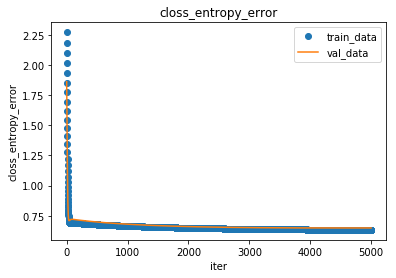

In [9]:
# iris_data
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2)
slr = ScratchLogisticRegression(max_iter=5000, lr=0.01)
slr.fit(X_train, y_train, X_test, y_test)
print(slr.predict(X_test))
print(slr.score(X_test, y_test))
plt.plot(slr.loss,'o',linewidth=2, label='train_data')
plt.title('closs_entropy_error')
plt.xlabel('iter')
plt.ylabel('closs_entropy_error')
plt.plot(slr.val_loss, label='val_data')
plt.legend()
plt.show()

In [10]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

def decision_region(X_train, y_train, model, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['versicolor', 'virginica']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は学習用データである。

    Parameters
    ----------------
    X_train : ndarray, shape(n_samples, 2)
        学習用データの特徴量
    y_train : ndarray, shape(n_samples,)
        学習用データの正解値
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2

    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X_train[:,0])-0.5, np.max(X_train[:,0])+0.5, step), np.arange(np.min(X_train[:,1])-0.5, np.max(X_train[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    pred = model.predict(mesh).reshape(mesh_f0.shape)

    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y_train)):
        plt.scatter(X_train[y_train==target][:, 0], X_train[y_train==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

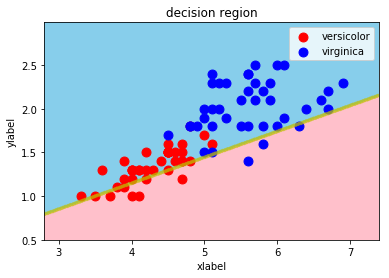

In [11]:
decision_region(X_train,y_train, model=slr)

0.8666666666666667
[0 1 1 0 1 1 1 1 0 1 1 1 0 1 1 1 1 1 0 1 0 1 1 0 1 1 0 0 1 1] [0 0 1 0 1 1 1 1 0 1 1 1 0 1 1 1 1 0 0 0 0 1 1 0 1 0 0 0 1 1]


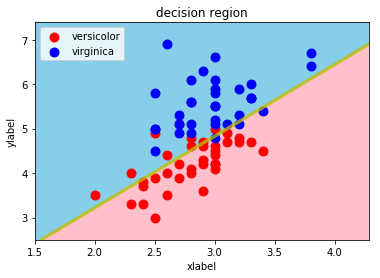

<Figure size 432x288 with 0 Axes>

In [12]:
# .pyfileの実行
%run ../ml-scratch/utils/scratch_logistic_regression.py --file_path  "C:/Users/umini/git-test/diveintocode-ml/ml-scratch/utils/df_vergicolor_and_virginica.csv" --max_iter 1000 --test_size=0.3